# Construindo Curvas e Superfícies por Pontos Especificados

Vamos ver uma forma de utilizar o determinante para construir equações de retas, círculos e seções cônicas em geral por pontos especificados no plano.

Referência: Álgebra Linear com aplicações / Anton Howard e Chris Rorres; trad. Claus Ivo Doering. - 8. ed. - Porto Alegre: Bookman, 2001.

In [10]:
# execute essa linha de código para importar as definições do plot_helper

import numpy
from numpy.linalg import inv, eig
from math import ceil
from matplotlib import pyplot, ticker, get_backend, rc
from mpl_toolkits.mplot3d import Axes3D
from itertools import cycle

# interactive backends
_int_backends = ['GTK3Agg', 'GTK3Cairo', 'MacOSX', 'nbAgg',
                 'Qt4Agg', 'Qt4Cairo', 'Qt5Agg', 'Qt5Cairo',
                 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 'WXCairo']
_backend = get_backend()   # get current backend name

# shrink figsize and fontsize when using %matplotlib notebook
if _backend in _int_backends:
    fontsize = 4
    fig_scale = 0.75
else:
    fontsize = 5
    fig_scale = 1

grey = '#808080'
gold = '#cab18c'   # x-axis grid
lightblue = '#0096d6'  # y-axis grid
green = '#008367'  # x-axis basis vector
red = '#E31937'    # y-axis basis vector
darkblue = '#004065'

pink, yellow, orange, purple, brown = '#ef7b9d', '#fbd349', '#ffa500', '#a35cff', '#731d1d'

quiver_params = {'angles': 'xy',
                 'scale_units': 'xy',
                 'scale': 1,
                 'width': 0.012}

grid_params = {'linewidth': 0.5,
               'alpha': 0.8}

def set_rc(func):
    def wrapper(*args, **kwargs):
        rc('font', family='serif', size=fontsize)
        rc('figure', dpi=200)
        rc('axes', axisbelow=True, titlesize=5)
        rc('lines', linewidth=1)
        func(*args, **kwargs)
    return wrapper

@set_rc
def plot_vector(vectors, tails=None):
    ''' Draw 2d vectors based on the values of the vectors and the position of their tails.
    
    Parameters
    ----------
    vectors : list.
        List of 2-element array-like structures, each represents a 2d vector.
    
    tails : list, optional.
        List of 2-element array-like structures, each represents the coordinates of the tail
        of the corresponding vector in vectors. If None (default), all tails are set at the
        origin (0,0). If len(tails) is 1, all tails are set at the same position. Otherwise,
        vectors and tails must have the same length.
    
    Examples
    --------
    >>> v = [(1, 3), (3, 3), (4, 6)]
    >>> plot_vector(v)      # draw 3 vectors with their tails at origin
    >>> t = [numpy.array((2, 2))]
    >>> plot_vector(v, t)   # draw 3 vectors with their tails at (2,2)
    >>> t = [[3, 2], [-1, -2], [3, 5]]
    >>> plot_vector(v, t)   # draw 3 vectors with 3 different tails
    '''   
    vectors = numpy.array(vectors)
    assert vectors.shape[1] == 2, "Each vector should have 2 elements."  
    if tails is not None:
        tails = numpy.array(tails)
        assert tails.shape[1] == 2, "Each tail should have 2 elements."
    else:
        tails = numpy.zeros_like(vectors)
    
    # tile vectors or tails array if needed
    nvectors = vectors.shape[0]
    ntails = tails.shape[0]
    if nvectors == 1 and ntails > 1:
        vectors = numpy.tile(vectors, (ntails, 1))
    elif ntails == 1 and nvectors > 1:
        tails = numpy.tile(tails, (nvectors, 1))
    else:
        assert tails.shape == vectors.shape, "vectors and tail must have a same shape"

    # calculate xlimit & ylimit
    heads = tails + vectors
    limit = numpy.max(numpy.abs(numpy.hstack((tails, heads))))
    limit = numpy.ceil(limit * 1.2)   # add some margins
    
    figsize = numpy.array([2,2]) * fig_scale
    figure, axis = pyplot.subplots(figsize=figsize)
    axis.quiver(tails[:,0], tails[:,1], vectors[:,0], vectors[:,1], color=darkblue, 
                  angles='xy', scale_units='xy', scale=1)
    axis.set_xlim([-limit, limit])
    axis.set_ylim([-limit, limit])
    axis.set_aspect('equal')

    # if xticks and yticks of grid do not match, choose the finer one
    xticks = axis.get_xticks()
    yticks = axis.get_yticks()
    dx = xticks[1] - xticks[0]
    dy = yticks[1] - yticks[0]
    base = max(int(min(dx, dy)), 1)   # grid interval is always an integer
    loc = ticker.MultipleLocator(base=base)
    axis.xaxis.set_major_locator(loc)
    axis.yaxis.set_major_locator(loc)
    axis.grid(True, **grid_params)
    
    # show x-y axis in the center, hide frames
    axis.spines['left'].set_position('center')
    axis.spines['bottom'].set_position('center')
    axis.spines['right'].set_color('none')
    axis.spines['top'].set_color('none')

@set_rc
def plot_transformation_helper(axis, matrix, *vectors, unit_vector=True, unit_circle=False, title=None):
    """ A helper function to plot the linear transformation defined by a 2x2 matrix.
    
    Parameters
    ----------
    axis : class matplotlib.axes.Axes.
        The axes to plot on.
    matrix : class numpy.ndarray.
        The 2x2 matrix to visualize.
    *vectors : class numpy.ndarray.
        The vector(s) to plot along with the linear transformation. Each array denotes a vector's
        coordinates before the transformation and must have a shape of (2,). Accept any number of vectors. 
    
    unit_vector : bool, optional.
        Whether to plot unit vectors of the standard basis, default to True.
    
    unit_circle: bool, optional.
        Whether to plot unit circle, default to False.
    
    title: str, optional.
        Title of the plot.
    """
    assert matrix.shape == (2,2), "the input matrix must have a shape of (2,2)"
    grid_range = 20
    x = numpy.arange(-grid_range, grid_range+1)
    X_, Y_ = numpy.meshgrid(x,x)
    I = matrix[:,0]
    J = matrix[:,1]
    X = I[0]*X_ + J[0]*Y_
    Y = I[1]*X_ + J[1]*Y_
    origin = numpy.zeros(1)
        
    # draw grid lines
    for i in range(x.size):
        axis.plot(X[i,:], Y[i,:], c=gold, **grid_params)
        axis.plot(X[:,i], Y[:,i], c=lightblue, **grid_params)
    
    # draw (transformed) unit vectors
    if unit_vector:
        axis.quiver(origin, origin, [I[0]], [I[1]], color=green, **quiver_params)
        axis.quiver(origin, origin, [J[0]], [J[1]], color=red, **quiver_params)

    # draw optional vectors
    color_cycle = cycle([pink, darkblue, orange, purple, brown])
    if vectors:
        for vector in vectors:
            color = next(color_cycle)
            vector_ = matrix @ vector.reshape(-1,1)
            axis.quiver(origin, origin, [vector_[0]], [vector_[1]], color=color, **quiver_params)

    # draw optional unit circle
    if unit_circle:
        alpha =  numpy.linspace(0, 2*numpy.pi, 41)
        circle = numpy.vstack((numpy.cos(alpha), numpy.sin(alpha)))
        circle_trans = matrix @ circle
        axis.plot(circle_trans[0], circle_trans[1], color=red, lw=0.8)

    # hide frames, set xlimit & ylimit, set title
    limit = 4
    axis.spines['left'].set_position('center')
    axis.spines['bottom'].set_position('center')
    axis.spines['left'].set_linewidth(0.3)
    axis.spines['bottom'].set_linewidth(0.3)
    axis.spines['right'].set_color('none')
    axis.spines['top'].set_color('none')
    axis.set_xlim([-limit, limit])
    axis.set_ylim([-limit, limit])
    if title is not None:
        axis.set_title(title)

@set_rc
def plot_linear_transformation(matrix, *vectors, unit_vector=True, unit_circle=False):
    """ Plot the linear transformation defined by a 2x2 matrix using the helper
    function plot_transformation_helper(). It will create 2 subplots to visualize some
    vectors before and after the transformation.
    
    Parameters
    ----------
    matrix : class numpy.ndarray.
        The 2x2 matrix to visualize.
    *vectors : class numpy.ndarray.
        The vector(s) to plot along with the linear transformation. Each array denotes a vector's
        coordinates before the transformation and must have a shape of (2,). Accept any number of vectors.
    
    unit_vector : bool, optional.
        Whether to plot unit vectors of the standard basis, default to True.
    
    unit_circle: bool, optional.
        Whether to plot unit circle, default to False.
    
    """
    figsize = numpy.array([4,2]) * fig_scale
    figure, (axis1, axis2) = pyplot.subplots(1, 2, figsize=figsize)
    plot_transformation_helper(axis1, numpy.identity(2), *vectors, unit_vector=unit_vector, unit_circle=unit_circle, title='Before transformation')
    plot_transformation_helper(axis2, matrix, *vectors, unit_vector=unit_vector, unit_circle=unit_circle, title='After transformation')

@set_rc
def plot_linear_transformations(*matrices, unit_vector=True, unit_circle=False):
    """ Plot the linear transformation defined by a sequence of n 2x2 matrices using the helper
    function plot_transformation_helper(). It will create n+1 subplots to visualize some
    vectors before and after each transformation.
    Parameters
    ----------
    *matrices : class numpy.ndarray.
        The 2x2 matrices to visualize. Accept any number of matrices.
    
    unit_vector : bool, optional.
        Whether to plot unit vectors of the standard basis, default to True.
    
    unit_circle: bool, optional.
        Whether to plot unit circle, default to False.
      
    """
    nplots = len(matrices) + 1
    nx = 2
    ny = ceil(nplots/nx)
    figsize = numpy.array([2*nx, 2*ny]) * fig_scale
    figure, axes = pyplot.subplots(nx, ny, figsize=figsize)

    for i in range(nplots):  # fig_idx 
        if i == 0:
            matrix_trans = numpy.identity(2)
            title = 'Antes da Transformação'
        else:
            matrix_trans = matrices[i-1] @ matrix_trans
            if i == 1:
                title = 'Depois de {} Trasnformação'.format(i)
            else:
                title = 'Depois de {} Transformações'.format(i)
        plot_transformation_helper(axes[i//nx, i%nx], matrix_trans, unit_vector=unit_vector, unit_circle=unit_circle, title=title)
    # hide axes of the extra subplot (only when nplots is an odd number)
    if nx*ny > nplots:
        axes[-1,-1].axis('off')
        
@set_rc
def plot_3d_transformation_helper(axis, matrix, grid=True, unit_sphere=False, title=None):
    """ A helper function to plot the linear transformation defined by a 3x3 matrix.
    
    Parameters
    ----------
    axis : class matplotlib.axes.Axes.
        The axes to plot on.
    matrix : class numpy.ndarray.
        The 3x3 matrix to visualize.
    grid : bool, optional.
        Whether to plot 3d grid lines, default to True.
    
    unit_sphere : bool, optional.
        Whether to plot unit sphere, default to False.
    
    title : str, optional.
        Title of the plot.
    """
    assert matrix.shape == (3,3), "the input matrix must have a shape of (3,3)"
    xcolor, ycolor, zcolor = '#0084b6', '#d8a322', '#FF3333'
    linewidth = 0.7
    if grid:
        grid_range = 2
        x = numpy.arange(-grid_range, grid_range+1)
        X, Y, Z = numpy.meshgrid(x,x,x)
        X_new = matrix[0,0]*X + matrix[0,1]*Y + matrix[0,2]*Z
        Y_new = matrix[1,0]*X + matrix[1,1]*Y + matrix[1,2]*Z
        Z_new = matrix[2,0]*X + matrix[2,1]*Y + matrix[2,2]*Z
        for i in range(x.size):
            for j in range(x.size):
                axis.plot(X_new[:,i,j], Y_new[:,i,j], Z_new[:,i,j], color=xcolor, linewidth=linewidth)
                axis.plot(X_new[i,:,j], Y_new[i,:,j], Z_new[i,:,j], color=ycolor, linewidth=linewidth)
                axis.plot(X_new[i,j,:], Y_new[i,j,:], Z_new[i,j,:], color=zcolor, linewidth=linewidth)
    
    if unit_sphere:
        u = numpy.linspace(0, 2 * numpy.pi, 100)
        v = numpy.linspace(0, numpy.pi, 100)
        X = 1 * numpy.outer(numpy.cos(u), numpy.sin(v))
        Y = 1 * numpy.outer(numpy.sin(u), numpy.sin(v))
        Z = 1 * numpy.outer(numpy.ones(numpy.size(u)), numpy.cos(v))
        X_new = matrix[0,0]*X + matrix[0,1]*Y + matrix[0,2]*Z
        Y_new = matrix[1,0]*X + matrix[1,1]*Y + matrix[1,2]*Z
        Z_new = matrix[2,0]*X + matrix[2,1]*Y + matrix[2,2]*Z
        axis.plot_surface(X_new, Y_new, Z_new, rstride=4, cstride=4, linewidth=0, cmap='ocean', alpha=0.6)

    if title is not None:
        axis.set_title(title)
    
    limit = 0
    if grid or unit_sphere:
        for array in (X_new, Y_new, Z_new):
            limit_ = numpy.max(numpy.abs(array))
            limit = max(limit, limit_)
    else:
        limit = 1
    axis.set_xlim(-limit, limit)
    axis.set_ylim(-limit, limit)
    axis.set_zlim(-limit, limit)
    # adjust the whitespace between ticks and axes to get a tighter plot
    for axis_str in ['x', 'y', 'z']:
        axis.tick_params(axis=axis_str, pad=-3)

@set_rc
def plot_3d_linear_transformation(matrix, grid=True, unit_sphere=False):
    """ Plot the linear transformation defined by a 3x3 matrix using the helper
    function plot_3d_transformation_helper(). It will create 2 subplots to visualize some
    vectors before and after the transformation.
    
    Parameters
    ----------
    matrix : class numpy.ndarray.
        The 3x3 matrix to visualize.
    grid : bool, optional.
        Whether to plot 3d grid lines, default to True.
    
    unit_sphere : bool, optional.
        Whether to plot unit sphere, default to False.
    """
    
    figsize = numpy.array([4,2]) * fig_scale
    figure = pyplot.figure(figsize=figsize)
    axis1 = figure.add_subplot(1, 2, 1, projection='3d')
    axis2 = figure.add_subplot(1, 2, 2, projection='3d')
    plot_3d_transformation_helper(axis1, numpy.identity(3), grid=grid, unit_sphere=unit_sphere, title='before transformation')
    plot_3d_transformation_helper(axis2, matrix, grid=grid, unit_sphere=unit_sphere, title='after transformation')

@set_rc
def plot_3d_linear_transformations(*matrices, grid=False, unit_sphere=False):
    """ Plot the linear transformation defined by a sequence of n 3x3 matrices using the helper
    function plot_3d_transformation_helper(). It will create n+1 subplots to visualize some
    vectors before and after each transformation.
    
    Parameters
    ----------
    *matrices : class numpy.ndarray.
        The 3x3 matrices to visualize. Accept any number of matrices. 
    grid : bool, optional.
        Whether to plot 3d grid lines, default to False.
    
    unit_sphere : bool, optional.
        Whether to plot unit sphere, default to False.
    """
    nplots = len(matrices) + 1
    nx = 2                 # number of figures per row
    ny = ceil(nplots/nx)   # number of figures per column
    figsize = numpy.array([2*nx, 2*ny]) * fig_scale
    figure = pyplot.figure(figsize=figsize)

    for i in range(nplots):  # fig_idx
        axis = figure.add_subplot(ny, nx, i+1, projection='3d')
        if i == 0:
            matrix_trans = numpy.identity(3)
            title = 'Antes da Transformação'
        else:
            matrix_trans = matrices[i-1] @ matrix_trans
            if i == 1:
                title = 'Depois de {} Transformação'.format(i)
            else:
                title = 'Depois de {} Transformações'.format(i)
        plot_3d_transformation_helper(axis, matrix_trans, grid=grid, unit_sphere=unit_sphere, title=title)

@set_rc
def plot_basis_helper(axis, I, J, *vectors, title=None, I_label='i', J_label='j'):
    """ A helper function to plot the 2D coordinate system determined by the basis I,J.
    
    Parameters
    ----------
    axis : class matplotlib.axes.Axes.
        The axes to plot on.
    I, J: class numpy.ndarray.
        The coordinates of the basis vector in the standard basis.
    *vectors : class numpy.ndarray.
        The vector(s) to plot along with the change of basis. Each array denotes a vector's
        coordinates in I-J coordinate system (not in the standard basis). Each vector must have
        a shape of (2,). Accept any number of vectors.
    
    I_label, J_label : str, optional.
        Label of the new basis, default to 'i' and 'j'.
    
    title: str, optional.
        Title of the plot.
    """
    grid_range = 20
    x = numpy.arange(-grid_range, grid_range+1)
    X_, Y_ = numpy.meshgrid(x,x)   # grid coordinates on the new basis
    X = I[0]*X_ + J[0]*Y_   # grid coordinates on the standard basis
    Y = I[1]*X_ + J[1]*Y_
    
    # draw origin
    origin = numpy.zeros(1)
    axis.scatter(origin, origin, c='black', s=3)

    # draw grid lines of the new coordinate system
    lw_grid = 0.4
    for i in range(x.size):
        axis.plot(X[i,:], Y[i,:], c=grey, lw=lw_grid)
        axis.plot(X[:,i], Y[:,i], c=grey, lw=lw_grid)
    
    # highlight new axes (spines)
    lw_spine = 0.7
    zero_id = numpy.where(x==0)[0][0]
    axis.plot(X[zero_id,:], Y[zero_id,:], c=gold, lw=lw_spine)
    axis.plot(X[:,zero_id], Y[:,zero_id], c=lightblue, lw=lw_spine)

    # draw basis vectors using quiver plot
    axis.quiver(origin, origin, [I[0]], [I[1]], color=gold, **quiver_params)
    axis.quiver(origin, origin, [J[0]], [J[1]], color=lightblue, **quiver_params)

    # draw input vector on new coordinate system
    bound = 5
    if vectors:
        for vector in vectors:
            M = numpy.transpose(numpy.vstack((I,J)))
            vector = M @ vector.reshape(-1,1)
            axis.quiver(origin, origin, [vector[0]], [vector[1]], color=red, **quiver_params)
            bound = max(ceil(numpy.max(numpy.abs(vector))), bound)
    
    # hide frames, set xlimit & ylimit, set title
    axis.set_xlim([-bound, bound])
    axis.set_ylim([-bound, bound])
    axis.axis('off')
    if title is not None:
        axis.set_title(title)

    # add text next to new basis vectors
    text_params = {'ha': 'center', 'va': 'center', 'size' : 6}
    axis.text((I[0]-J[0])/2*1.1, (I[1]-J[1])/2*1.1, r'${}$'.format(I_label), color=gold, **text_params)
    axis.text((J[0]-I[0])/2*1.1, (J[1]-I[1])/2*1.1, r'${}$'.format(J_label), color=lightblue, **text_params)

@set_rc
def plot_basis(I, J, *vectors):
    """ Plot 2d vectors on the coordinates system defined by basis I and J using the helper funtion
    plot_basis_helper().
    
    Parameters
    ----------
    I, J: class numpy.ndarray.
        The coordinates of the basis vector in the standard basis.
    *vectors : class numpy.ndarray.
        The vector(s) to plot along with the change of basis. Each array denotes a vector's
        coordinates in I-J coordinate system (not in the standard basis). Each vector must have
        a shape of (2,). Accept any number of vectors.
    """
    figsize = numpy.array([2,2]) * fig_scale
    figure, axis = pyplot.subplots(figsize=figsize)
    plot_basis_helper(axis, I, J, *vectors)

@set_rc
def plot_change_basis(I, J, *vectors):
    """ Create a side-by-side plot of some vectors both on the standard basis and on the new basis
    defined by I and J, using the helper function plot_basis_helper().
    
    Parameters
    ----------
    I, J: class numpy.ndarray.
        The coordinates of the basis vector in the standard basis.
    *vectors : class numpy.ndarray.
        The vector(s) to plot along with the change of basis. Each array denotes a vector's
        coordinates in I-J coordinate system (not in the standard basis). Each vector must have
        a shape of (2,). Accept any number of vectors.
    """
    figsize = numpy.array([4,2]) * fig_scale
    figure, (axis1, axis2) = pyplot.subplots(1, 2, figsize=figsize)
    M = numpy.transpose(numpy.vstack((I,J)))
    M_inv = inv(M)
    vectors_ = [ M_inv @ vector.reshape(-1, 1) for vector in vectors ]
    plot_basis_helper(axis1, numpy.array([1,0]), numpy.array([0,1]), *vectors, title='standard basis')
    plot_basis_helper(axis2, I, J, *vectors_, title='new basis', I_label='a', J_label='b')

@set_rc
def plot_eigen(matrix):
    """ Visualize the eigendecomposition of a 2x2 matrix as a combination of changing basis 
    and scaling transformation, using the helper function plot_basis_helper().
    Parameters
    ----------
    matrix : class numpy.ndarray.
        The 2x2 matrix to visualize.
    """
    figsize = numpy.array([4,4]) * fig_scale
    figure, axes = pyplot.subplots(2, 2, figsize=figsize)
    
    eigenvalues, eigenvectors = eig(matrix)
    C = eigenvectors
    D = numpy.diag(eigenvalues)
    C_inv = inv(C)

    alpha =  numpy.linspace(0, 2*numpy.pi, 41)
    circle = numpy.vstack((numpy.cos(alpha), numpy.sin(alpha)))

    plot_basis_helper(axes[0,0], numpy.array([1,0]), numpy.array([0,1]), title=r'coords in standard basis $\mathbf{x}$')
    plot_basis_helper(axes[0,1], C[:,0], C[:,1], title=r'change to new basis $C^{-1}\mathbf{x}$', I_label='a', J_label='b')
    plot_basis_helper(axes[1,0], C[:,0], C[:,1], title=r'scale along new basis $DC^{-1}\mathbf{x}$', I_label='a', J_label='b')
    plot_basis_helper(axes[1,1], numpy.array([1,0]), numpy.array([0,1]), title=r'change back to standard basis $CDC^{-1}\mathbf{x}$')

    circle_trans = matrix @ circle
    for axis in axes[0]:
        axis.plot(circle[0], circle[1], color=red, lw=0.8)
    for axis in axes[1]:
        axis.plot(circle_trans[0], circle_trans[1], color=red, lw=0.8)

if __name__ == "__main__":
    pass

# funções definidas por L Barba e T Wang para uma apresentação no evento SciPy 2019 
# aplicação das funções para a aula do professor Edmar Candeia Gurjão feitas por Alysson Machado

In [11]:
import numpy # importando a biblioteca numpy do Python
%matplotlib notebook
%matplotlib inline 
from matplotlib import pyplot # importando a biblioteca matplotlib do Python

In [12]:
import sys # importa as definições feitas no plot_helper
sys.path.append('../scripts/')

# Ao importar, teremos acesso as funções: 
# plot_vector, plot_linear_transformation, plot_linear_transformations

$Uma$ $Reta$ $Por$ $Dois$ $Pontos:$

Suponha que (x1,y1) e (x2,y2) são dois pontos distintos no plano. existe uma única reta 
$$c1x + c2y + c3 = 0$$ 
que passa por esses dois pontos. Observe que c1, c2 e c3 não são todos nulos e que estes coeficientes são únicos a menos de uma constante multiplicativa. Como (x1,y1) e (x2,y2) estão na reta, substituindo-se obtemos as duas equações:
$$1-) c1x1 + c2y1 + c3 = 0$$
$$2-) c1x2 + c2y2 + c3 = 0$$
Essas três equações podem ser agrupadas da seguinte forma:
$$xc1 + yc2 + c3 = 0$$
$$x1c1 + y1c2 + c3 = 0$$
$$x2c1 + y2c2 + c3 = 0$$
que é um sistema linear homogêneo de três equações em c1, c2 e c3. Como c1, c2 e c3 não são todos nulos, este sistema tem uma solução não-trivial, de modo que o determinante do sistema deve ser zero. Ou seja:
$$\begin{bmatrix}
         x & y & 1 \\
         x1 & y1 & 1 \\
         x2 & y2 & 1 \\
         \end{bmatrix} = 0$$

Dai, temos o teorema: Um sistema linear homogêneo com o mesmo número de equações e de incógnitas tem uma solução não-trivial se, e somente se, o determinante da matriz de coeficientes é zero.

$Ex: $Encontre a equação da reta que passa pelos dois pontos (2,1) e (3,7).

$\begin{bmatrix}
         x & y & 1 \\
         2 & 1 & 1 \\
         3 & 7 & 1 \\
         \end{bmatrix}$
         

A expansão deste determinante em co-fatores ao longo da primeira linha, vai nos dar a equação da reta:

In [13]:
# definindo um sistema linear homogêneo de equações
matriz = numpy.array([[2,1,1],[3,7,1]]) 
# matriz de co-fatores do elemento [1,1]
constanteX = numpy.dot((-1) ** (1 + 1), numpy.linalg.det(numpy.delete(matriz,0,axis=1))) 
# matriz de co-fatores do elemento [1,2]
constanteY = numpy.dot((-1) ** (1 + 2), numpy.linalg.det(numpy.delete(matriz,1,axis=1))) 
# matriz de co-fatores do elemento [1,3]
constante = numpy.dot((-1) ** (1 + 3), numpy.linalg.det(numpy.delete(matriz,2,axis=1))) 

In [14]:
print("Equação da reta: {:.2f}x {:.2f}y {:.2f} = 0".format(constanteX, constanteY, constante)) # imprime a equação da reta

Equação da reta: -6.00x 1.00y 11.00 = 0


E temos a equação: $-6x + y + 11 = 0$

Text(0.5, 1.0, 'Equação da Reta')

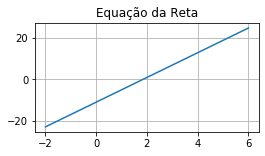

In [19]:
valoresX = numpy.linspace(-2,6) # define valores arbitrários para a variável x, entre -2 e 6
y1 = 6.0 # coordenadas associadas a y
b1= -11.0 # valor resultante da operação do sistema
pyplot.figure(figsize = (4,2)) # definindo o tamanho da figura
pyplot.plot(valoresX, y1 * valoresX + b1) # plota a reta y = 6x - 11
pyplot.box(True) # adição da caixa preta nas bordas do gráfico
pyplot.grid(True) # adição do quadriculado do gráfico
pyplot.title("Equação da Reta") # Título da Reta

$Um$ $Círculo$ $Por$ $Três$ $Pontos$

Suponha que (x1,y1), (x2,y2) e (x3,y3) são três pontos distintos não-colineares do plano. Da Geometria Analítica sabemos que existe um único círculo, digamos,
$$c_{1}(x^{2} + y^{2}) + c_{2}x + c_{3}y + c_{4} = 0$$
que passa por esses três pontos. Substituindo as coordenadas destes pontos nesta equação, obtemos:
$$1-) c_{1}(x1^{2} + y1^{2}) + c_{2}x1 + c_{3}y1 + c_{4} = 0$$
$$2-) c_{1}(x2^{2} + y2^{2}) + c_{2}x2 + c_{3}y2 + c_{4} = 0$$
$$3-) c_{1}(x3^{2} + y3^{2}) + c_{2}x3 + c_{3}y3 + c_{4} = 0$$
Como antes, as equações formam um sistema linear homogêneo com uma solução não-trivial em c1, c2, c3 e c4. Assim, o determinante da matriz de coeficientes é zero.
$$\begin{bmatrix}
          x^2 + y^2 & x & y & 1 \\
          x1^2 + y1^2 & x1 & y1 & 1 \\
          x2^2 + y2^2 & x2 & y2 & 1 \\
          x3^2 + y3^2 & x3 & y3 & 1 \\
          \end{bmatrix}$$

$Ex: $Encontre a equação do círculo que passa pelos três pontos (1,7) e (6,2) e (4,6).

A expansão deste determinante em co-fatores ao longo da primeira linha, vai nos dar a equação da reta:

$\begin{bmatrix}
         x^2 + y^2 & x & y & 1 \\
         50 & 1 & 7 & 1 \\
         40 & 6 & 2 & 1 \\
         52 & 4 & 6 & 1 \\
         \end{bmatrix} = 0$

In [16]:
# definindo um sistema linear homogêneo de equações
matriz = numpy.array([[50,1,7,1],[40,6,2,1],[52,4,6,1]])
# matriz de co-fatores do elemento [1,1]
constanteXY = numpy.dot((-1) ** (1 + 1), numpy.linalg.det(numpy.delete(matriz,0,axis=1))) 
# matriz de co-fatores do elemento [1,2]
constanteX = numpy.dot((-1) ** (1 + 2), numpy.linalg.det(numpy.delete(matriz,1,axis=1))) 
# matriz de co-fatores do elemento [1,3]
constanteY = numpy.dot((-1) ** (1 + 3), numpy.linalg.det(numpy.delete(matriz,2,axis=1))) 
# matriz de co-fatores do elemento [1,4]
constante = numpy.dot((-1) ** (1 + 4), numpy.linalg.det(numpy.delete(matriz,3,axis=1))) 

In [17]:
print("Equação da circunferência: {:.2f}(x² + y²) {:.2f}x {:.2f}y {:.2f} = 0".format(constanteXY,constanteX,constanteY,constante))

Equação da circunferência: 10.00(x² + y²) -20.00x -40.00y -200.00 = 0


Temos a equação da circunferência: $10(x² + y²) - 20x - 40y - 200 = 0$

$$1-) (x² + y²) - 2x - 4y - 20 = 0$$
$$2-) (x² - 2x + 1) - 1 + (y² - 4y + 2) - 4 - 20 = 0$$
$$3-) (x - 1)² + (y - 2)² = 5²$$

De forma mais simplificada ainda:
$$1-) x = 1 + 5*cos(t)$$
$$2-) y = 2 + 5*sen(t)$$

Text(0.5, 1.0, 'Equação da circunferência')

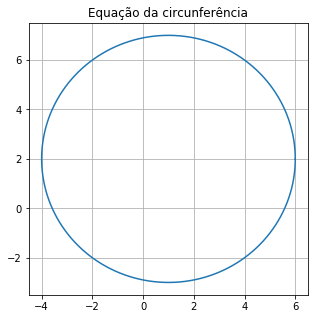

In [18]:
x0, y0, raio = 1, 2, 5 # definindo as coordenadas do centro e o raio do círculo
teta = numpy.arange(0, 2*numpy.pi, 0.01) # dominio da função (passo 0.01 para melhorar a precisão)
x = x0 + raio * numpy.cos(teta) # calculando x
y = y0 + raio * numpy.sin(teta) # calculando y
pyplot.figure(figsize = (5,5)) # definindo o tamanho da figura
pyplot.plot(x,y) # plota o gráfico
pyplot.box(True) # adição da caixa preta nas bordas do gráfico
pyplot.grid(True) # desenho do quadriculado do gráfico
pyplot.title("Equação da circunferência") # título do gráfico

$Uma$ $Cônica$ $Arbitrária$ $Por$ $Cinco$ $Pontos$

A equação  geral de uma seção cônica arbitrária no plano (uma parábola, hipérbole ou elipse, ou formas degeneradas destas) é dada por $$c1x^2 + c2xy + c3y^2 + c4x + c5y + c6 = 0$$
Esta equação contém seis coeficientes, mas nós podemos reduzir este número a cinco se dividirmos todos por um que não seja zero. Assim,  basta determinar cinco coeficientes e portanto cinco pontos distintos do plano são suficientes para determinar a equação da seção cônica. Como antes, a equação pode ser posta na forma de determinante:

$\begin{bmatrix}
         x² & xy & y² & x & y & 1\\
         x1² & x1y1 & y1² & x1 & y1 & 1\\
         x2² & x2y2 & y2² & x2 & y2 & 1\\
         x3² & x3y3 & y3² & x3 & y3 & 1\\
         x4² & x4y4 & y4² & x4 & y4 & 1\\
         x5² & x5y5 & y5² & x5 & y5 & 1\\
         \end{bmatrix} = 0$

$Ex: $Um astrônomo que deseja determinar a órbita de um asteróide em torno do Sol coloca um sistema de coordenadas cartesianas no plano da órbita, com o Sol na origem. Ao longo dos eixos são usadas unidades astronômicas (1 UA = 1 unidade astronômica = distância média da Terra ao Sol = 149.504.200 km). Pela  Primeira Lei de Kepler, a órbita deve ser uma elípse, de modo que o astrônomo faz cinco observações do asteróide em cinco tempos distintos: os cinco pontos ao longo da órbita são (8,025;8,310), (10,170;6,355), (11,202;3,212), (10,736;0,375), (9,092;-2.267). Encontre a equação da órbita.

$\begin{bmatrix}
         x² & xy & y² & x & y & 1 \\
         64,401 & 66,688 & 69,056 & 8,025 & 8,310 & 1 \\
         103,429 & 64,630 & 40,386 & 10,170 & 6,355 & 1 \\
         125,485 & 35,981 & 10,317 & 11,202 & 3,212 & 1 \\
         115,262 & 4,026 & 0,141 & 10,736 & 0,375 & 1 \\
         82,664 & -20,612 & 5,139 & 9,092 & -2,267 & 1 \\
         \end{bmatrix} = 0$

A expansão desse determinante em co-fatores ao longo da primeira linha é:

In [20]:
# definindo um sistema linear homogêneo de equações
matriz = numpy.array([[64.401, 66.688, 69.056, 8.025, 8.310, 1], 
                      [103.429, 64.630, 40.386, 10.170, 6.355, 1],
                      [125.485, 35.981, 10.317, 11.202, 3.212, 1],
                      [115.262, 4.026, 0.141, 10.736, 0.375, 1],
                      [82.664, -20.612, 5.139, 9.092, -2.267, 1]])
# matriz de co-fatores do elemento [1,1]
constanteX2 = numpy.dot((-1) ** (1 + 1), numpy.linalg.det(numpy.delete(matriz,0,axis=1))) 
# matriz de co-fatores do elemento [1,2]
constanteXY = numpy.dot((-1) ** (1 + 2), numpy.linalg.det(numpy.delete(matriz,1,axis=1))) 
# matriz de co-fatores do elemento [1,3]
constanteY2 = numpy.dot((-1) ** (1 + 3), numpy.linalg.det(numpy.delete(matriz,2,axis=1))) 
# matriz de co-fatores do elemento [1,4]
constanteX = numpy.dot((-1) ** (1 + 4), numpy.linalg.det(numpy.delete(matriz,3,axis=1))) 
# matriz de co-fatores do elemento [1,5]
constanteY = numpy.dot((-1) ** (1 + 5), numpy.linalg.det(numpy.delete(matriz,4,axis=1)))
# matriz de co-fatores do elemento [1,6]
constante = numpy.dot((-1) ** (1 + 6), numpy.linalg.det(numpy.delete(matriz,5,axis=1))) 

In [21]:
# imprime a equação geral da órbita
print("Equação da órbita: {:.3f}x² {:.3f}xy {:.3f}y² {:.3f}x {:.3f}y {:.3f}".format(constanteX2, constanteXY, constanteY2, constanteX, constanteY, constante))

Equação da órbita: 386.872x² -102.830xy 445.995y² -2478.513x -1428.452y -17095.562


$Um$ $Plano$ $Por$ $Três$ $Pontos$

O plano no espaço tridimensional de equação:
$$c1x +c2y + c3z + c4 = 0$$
que passa por três pontos não-colineares (x1,y1,z1), (x2,y2,z2) e (x3,y3,z3) é dado pela equação em formato de determinante:
$$\begin{bmatrix}
          x & y & z & 1 \\
          x1 & y1 & z1 & 1 \\
          x2 & y2 & z2 & 1 \\
          x3 & y3 & z3 & 1 \\
          \end{bmatrix} = 0$$

$Ex: $Qual a equação do plano que passa pelos três pontos não-colineares (1,1,0),(2,0,-1) e (2,9,2).
$$$$
A expansão desse determinante em co-fatores ao longo da primeira linha é:
$$\begin{bmatrix}
          x & y & z & 1 \\
          1 & 1 & 0 & 1 \\
          2 & 0 & -1 & 1 \\
          2 & 9 & 2 & 1 \\
          \end{bmatrix} = 0$$

In [23]:
# definindo um sistema linear homogêneo de equações
matriz = numpy.array([[1,1,0,1], [2,0,-1,1], [2,9,2,1]])
# matriz de co-fatores do elemento [1,1]
constanteX = numpy.dot((-1) ** (1 + 1), numpy.linalg.det(numpy.delete(matriz,0,axis=1))) 
# matriz de co-fatores do elemento [1,2]
constanteY = numpy.dot((-1) ** (1 + 2), numpy.linalg.det(numpy.delete(matriz,1,axis=1))) 
# matriz de co-fatores do elemento [1,3]
constanteZ = numpy.dot((-1) ** (1 + 3), numpy.linalg.det(numpy.delete(matriz,2,axis=1))) 
# matriz de co-fatores do elemento [1,4]
constante = numpy.dot((-1) ** (1 + 4), numpy.linalg.det(numpy.delete(matriz,3,axis=1))) 

In [24]:
# imprime a equação do plano
print("A equação do plano é: {:.2f}x {:.2f}y {:.2f}z {:.2f} = 0".format(constanteX, constanteY, constanteZ, constante))

A equação do plano é: 6.00x -3.00y 9.00z -3.00 = 0


$Uma$ $Esfera$ $Por$ $Quatro$ $Pontos$

A esfera no espaço tridimensional de equação:
$$c1(x² + y² + z²) + c2x + c3y + c4z + c5 = 0$$
que passa por quatro pontos não-coplanares (x1, y1, z1), (x2, y2, z2), (x3, y3, z3) e (x4, y4, z4) é dado pela equação em formato de determinante:
$$\begin{bmatrix}
          x² & y² & z² & x & y & z \\
          x1² & y1² & z1² & x1 & y1 & z1 \\
          x2² & y2² & z2² & x2 & y2 & z2 \\
          x3² & y3² & z3² & x3 & y3 & z3 \\
          x4² & y4² & z4² & x4 & y4 & z4 \\
          \end{bmatrix} = 0$$

$Ex: $Qual a equação que passa pelos quatro pontos não-coplanares (0,3,2), (1,-1,1), (2,1,0) e (5,1,3).
$$$$
A expansão desse determinante em co-fatores ao longo da primeira linha é:
$$\begin{bmatrix}
          x² + y² + z² & x & y & z & 1 \\
          13 & 0 & 3 & 2 & 1 \\
          3 & 1 & -1 & 1 & 1 \\
          5 & 2 & 1 & 0 & 1 \\
          35 & 5 & 1 & 3 & 1 \\
          \end{bmatrix} = 0$$

In [26]:
# definindo um sistema linear homogêneo de equações
matriz = numpy.array([[13,0,3,2,1], [3,1,-1,1,1], [5,2,1,0,1], [35,5,1,3,1]])
# matriz de co-fatores do elemento [1,1]
constanteX2Y2Z2 = numpy.dot((-1) ** (1 + 1), numpy.linalg.det(numpy.delete(matriz,0,axis=1))) 
# matriz de co-fatores do elemento [1,2]
constanteX = numpy.dot((-1) ** (1 + 2), numpy.linalg.det(numpy.delete(matriz,1,axis=1))) 
# matriz de co-fatores do elemento [1,3]
constanteY = numpy.dot((-1) ** (1 + 3), numpy.linalg.det(numpy.delete(matriz,2,axis=1))) 
# matriz de co-fatores do elemento [1,4]
constanteZ = numpy.dot((-1) ** (1 + 4), numpy.linalg.det(numpy.delete(matriz,3,axis=1))) 
# matriz de co-fatores do elemento [1,5]
constante = numpy.dot((-1) ** (1 + 5), numpy.linalg.det(numpy.delete(matriz,4,axis=1))) 

In [27]:
# imprime a equação da esfera
print("A equação da esfera é {:.2f}(x² + y² + z²) {:.2f}x {:.2f}y {:.2f}z {:.2f} = 0".format(constanteX2Y2Z2, constanteX, constanteY, constanteZ, constante))

A equação da esfera é -36.00(x² + y² + z²) 144.00x 72.00y 216.00z -180.00 = 0
